In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from PIL import Image
from numpy import *
from pylab import *
import os
import matplotlib
%matplotlib inline

In [2]:
def process_image(imagename,resultname,params="--edge-thresh 10 --peak-thresh 5"):
    """ Process an image and save the results in a file. """

    if imagename[-3:] != 'pgm':
        # create a pgm file
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'

    cmmd = str("sift "+imagename+" --output="+resultname+
                " "+params)
    os.system(cmmd)
    print 'processed', imagename, 'to', resultname


def read_features_from_file(filename):
    """ Read feature properties and return in matrix form. """
    
    f = loadtxt(filename)
    return f[:,:4],f[:,4:] # feature locations, descriptors


def write_features_to_file(filename,locs,desc):
    """ Save feature location and descriptor to file. """
    savetxt(filename,hstack((locs,desc)))
    

def plot_features(im,locs,circle=False):
    """ Show image with features. input: im (image as array), 
        locs (row, col, scale, orientation of each feature). """

    def draw_circle(c,r):
        t = arange(0,1.01,.01)*2*pi
        x = r*cos(t) + c[0]
        y = r*sin(t) + c[1]
        plot(x,y,'b',linewidth=2)

    imshow(im)
    if circle:
        for p in locs:
            draw_circle(p[:2],p[2]) 
    else:
        plot(locs[:,0],locs[:,1],'ob')
    axis('off')


def match(desc1,desc2):
    """ For each descriptor in the first image, 
        select its match in the second image.
        input: desc1 (descriptors for the first image), 
        desc2 (same for second image). """
    
    desc1 = array([d/linalg.norm(d) for d in desc1])
    desc2 = array([d/linalg.norm(d) for d in desc2])
    
    dist_ratio = 0.6
    desc1_size = desc1.shape
    
    matchscores = zeros((desc1_size[0]),'int')
    desc2t = desc2.T # precompute matrix transpose
    for i in range(desc1_size[0]):
        dotprods = dot(desc1[i,:],desc2t) # vector of dot products
        dotprods = 0.9999*dotprods
        # inverse cosine and sort, return index for features in second image
        indx = argsort(arccos(dotprods))
        
        # check if nearest neighbor has angle less than dist_ratio times 2nd
        if arccos(dotprods)[indx[0]] < dist_ratio * arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    
    return matchscores


def appendimages(im1,im2):
    """ Return a new image that appends the two images side-by-side. """
    
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))), axis=0)
    # if none of these cases they are equal, no filling needed.
    
    return concatenate((im1,im2), axis=1)


def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ Show a figure with lines joining the accepted matches
        input: im1,im2 (images as arrays), locs1,locs2 (location of features), 
        matchscores (as output from 'match'), show_below (if images should be shown below). """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = vstack((im3,im3))
    
    # show image
    imshow(im3)
    
    # draw lines for matches
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    axis('off')


def match_twosided(desc1,desc2):
    """ Two-sided symmetric version of match(). """
    
    matches_12 = match(desc1,desc2)
    matches_21 = match(desc2,desc1)
    
    ndx_12 = matches_12.nonzero()[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0
    
    return matches_12


processed tmp.pgm to 2.sift


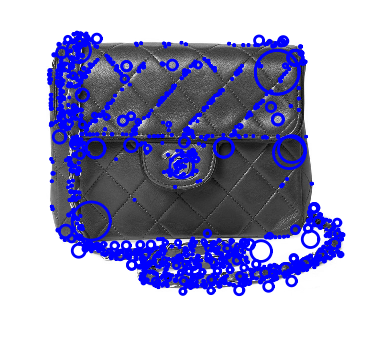

In [3]:
imname = '2.jpg'

im1 = array(Image.open(imname).convert('L'))

process_image(imname,'2.sift')

l1,d1 = read_features_from_file('2.sift')

figure()
gray()
plot_features(im1,l1,circle=True)
show()